```{include} ../math-definitions.md
```

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from statsmodels.tsa.arima_process import ArmaProcess # MODELO TEORICO

In [2]:
def graficar_impulso_respuesta(fig, proceso, maxlag=18, **kwargs):
    fig.add_trace(go.Bar(y=proceso.impulse_response(maxlag)), **kwargs)

def graficar_autocorrelacion(fig, proceso, maxlag=12, **kwargs):
    rezagos = 1 + np.arange(maxlag)
    fig.add_trace(go.Bar(x=rezagos, y=proceso.acf(maxlag+1)[1:]), **kwargs)

def graficar_autocorrelacion_parcial(fig, proceso, maxlag=12, **kwargs):
    rezagos = 1 + np.arange(maxlag)
    fig.add_trace(go.Bar(x=rezagos, y=proceso.pacf(maxlag+1)[1:]), **kwargs)    

def graficar_simulacion(fig, proceso, nperiodos=120, **kwargs):
    fig.add_trace(go.Scatter(y=proceso.generate_sample(nperiodos)), **kwargs)

def graficar_raices(fig, raices):
    r, theta = np.abs(1/raices), np.angle(1/raices, True)
    rmax = 1.0 if np.max(r) < 1.0 else np.maximum(r)

    fig.add_trace(go.Scatterpolar(
            r=r,
            theta=theta,
            mode = 'markers',
            marker_size=14
        ))

    fig.update_layout(
                title='Raíces inversas del polinomio de rezagos',
                polar={'angularaxis': {'thetaunit': 'radians', 'dtick': np.pi / 4},
                    'radialaxis': {'tickvals': [0.0, 1.0], 'range': [0, rmax]}}
            )

opciones = dict(height=300, width=800, showlegend=False, margin=dict(l=40, r=20, t=40, b=20))

# Proceso de media móvil MA(q)

## Proceso media móvil de primer orden: MA(1)

Sea $\left\{\epsilon_t\right\}_{t=-\infty}^\infty$ un proceso ruido blanco. Se define el proceso MA(1) como:
\begin{align*}
y_t  &= \mu + \epsilon_t + \theta\epsilon_{t-1} \\
     &= \mu + (1+\theta \Lag)\epsilon_t
\end{align*}

Su valor esperado es:
\begin{align*}
\E[y_t]  &= \mu + \E[\epsilon_t] + \theta\E[\epsilon_{t-1}] \\
         &= \mu + 0 + 0\theta \\
         &= \mu
\end{align*}


Su varianza es
\begin{align*}
\Var[y_t] &\equiv \E\left[(y_t - \E[y_t])^2\right] \\
          &= \E\left[(y_t - \mu)^2\right] \\
          &= \E\left[(\epsilon_t + \theta\epsilon_{t-1})^2\right] \\
          &= \E\left[\epsilon^2_t + 2\theta\epsilon_t\epsilon_{t-1} + \theta^2\epsilon^2_{t-1}\right] \\
          &= \E\left[\epsilon^2_t\right] + 2\theta\E\left[\epsilon_t\epsilon_{t-1}\right] + \theta^2\E\left[\epsilon^2_{t-1}\right] \\
          &= \sigma^2 + 2\theta\times 0  \theta^2\sigma^2 \\
          &= (1 + \theta^2)\sigma^2
\end{align*}


Su autocovarianza $j$, para $j\geq 1$, es
\begin{align*}
\Cov[y_t, y_{t-j}] &= \E\left[(y_t - \mu)(y_{t-j} - \mu)\right] \\
                   &= \E\left[(\epsilon_{t} + \theta\epsilon_{t-1})(\epsilon_{t-j} + \theta\epsilon_{t-j-1})\right] \\
                   &= \E\left[\epsilon_{t}\epsilon_{t-j} + \theta\epsilon_{t}\epsilon_{t-j-1} + \theta\epsilon_{t-1}\epsilon_{t-j} + \theta^2\epsilon_{t-1}\epsilon_{t-j-1}\right] \\
                   &= 0 + \theta\times 0 + \theta\E\left[\epsilon_{t-1}\epsilon_{t-j}\right]  + \theta^2\times 0 \\
                   &= \theta\E\left[\epsilon_{t-1}\epsilon_{t-j}\right]
                   = \begin{cases}
\theta\sigma^2 &, \text{ si }j=1 \\
0 &, \text{ si }j>1
\end{cases}
\end{align*}


Por lo tanto, su función de autocorrelación es
\begin{equation*}
\rho_j = \begin{cases}
\frac{\theta}{1+\theta^2} &, \text{ si } j=1 \\
0 &, \text{ si } j>1
\end{cases}
\end{equation*}

Notemos que la función de autocorrelación de $y_t  = \mu + \epsilon_t + \theta\epsilon_{t-1}$ es la misma que para el proceso $z_t  = \mu + \epsilon_t + \frac{1}{\theta}\epsilon_{t-1}$

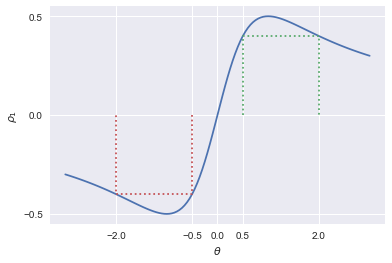

In [3]:
plt.style.use('seaborn')

rho1 = lambda x: x / (1+x**2)
theta = np.linspace(-3,3, 121)

fig, ax = plt.subplots()
ax.plot(theta, rho1(theta))

ax.plot([0.5,0.5,2.0,2.0], [0,rho1(0.5), rho1(2.0), 0], ':')
ax.plot([-0.5,-0.5,-2.0,-2.0], [0,rho1(-0.5), rho1(-2.0), 0], ':')
ax.set_xticks([-2.0,-0.5,0.0,0.5, 2.0])
ax.set_yticks([-0.5,0,0.5])
ax.set_xlabel(r'$\theta$')
ax.set_ylabel(r'$\rho_1$');

Resumiendo los resultados que hemos obtenido
\begin{align*}
\E[y_t]   &= \mu \\
\Var[y_t] &= (1 + \theta^2)\sigma^2 \\
\Cov[y_t, y_{t-j}] &= \begin{cases}\theta\sigma^2 &, \text{ si }j=1 \\0 &, \text{ si }j>1 \end{cases}
\end{align*}

vemos que ninguno de estos momentos depende del tiempo $t$, por lo que el proceso MA(1) siempre es covarianza-estacionario.

{{ empieza_ejemplo }} MA(1) con $\theta>0${{ fin_titulo_ejemplo }}

$y_t  = \epsilon_t + 0.8\epsilon_{t-1}$

In [4]:
modelo_ma1p = ArmaProcess.from_coeffs(macoefs=[0.8])

fig = make_subplots(rows=1, cols=2, subplot_titles=('Simulación', 'Autocorrelación'))
graficar_simulacion(fig, modelo_ma1p, row=1, col=1)
graficar_autocorrelacion(fig, modelo_ma1p, row=1, col=2)
fig.update_layout(**opciones)
fig.show()

{{ termina_ejemplo }}

{{ empieza_ejemplo }} MA(1) con $\theta<0${{ fin_titulo_ejemplo }}
$y_t  = \epsilon_t - 0.8\epsilon_{t-1}$

In [5]:
modelo_ma1n = ArmaProcess.from_coeffs(macoefs=[-0.8])

fig = make_subplots(rows=1, cols=2, subplot_titles=('Simulación', 'Autocorrelación'))
graficar_simulacion(fig, modelo_ma1n, row=1, col=1)
graficar_autocorrelacion(fig, modelo_ma1n, row=1, col=2)
fig.update_layout(**opciones)
fig.show()

{{ termina_ejemplo }}


## Invertibilidad de un proceso MA(1)

Supongamos que $\mu=0$, con lo que el proceso es
\begin{equation*}
y_t  = \epsilon_t + \theta\epsilon_{t-1} = (1+\theta \Lag)\epsilon_t
\end{equation*}

Siempre que $|\theta|< 1$ podemos invertir el polinomio $(1+\theta \Lag)$:
\begin{equation*}
(1+\theta \Lag)^{-1} = (1 - \theta\Lag + \theta^2\Lag^2 - \theta^3\Lag^3 + \dots)
\end{equation*}

con lo que
\begin{align*}
\epsilon_t &= (1+\theta \Lag)^{-1}y_t \\
 &= (1 - \theta\Lag + \theta^2\Lag^2 - \theta^3\Lag^3 + \dots)y_t \\
 &= y_{t} - \theta y_{t-1} + \theta^2 y_{t-2} - \theta^3 y_{t-3} + \dots\\
\Rightarrow y_{t} &= \epsilon_t + \theta y_{t-1} - \theta^2 y_{t-2} + \theta^3 y_{t-3} - \dots
\end{align*}

Es decir, podemos representar el proceso MA(1) como un proceso AR($\infty$).


Recordemos que si bien un proceso MA(1) con parámetro $\theta$ tiene exactamente la misma función de autocorrelación que un proceso con parámetro $\frac{1}{\theta}$, solo uno de ellos puede ser invertible, porque si $|\theta|<1$, entonces $|\frac{1}{\theta}|>1$.

Para ciertos métodos de estimación, sólo será posible estimar el modelo MA(1) si es invertible.

Por ello, para modelos no invertibles se suele cambiar el parámetro por su recíproco.




## El proceso MA(q)

Es fácil extender el proceso MA(1) para incluir más rezagos.

El proceso MA(q) es
\begin{align*}
y_t  &= \mu + \epsilon_t + \theta_1\epsilon_{t-1} + \dots + \theta_q\epsilon_{t-q} \\
     &= \mu + \left(1 + \theta_1 \Lag + \dots + \theta_q \Lag^q\right)\epsilon_t\\
     &= \mu + \Theta(\Lag)\epsilon_t
\end{align*}
con $\epsilon_t$ ruido blanco.

Su valor esperado es
\begin{align*}
\E\left(y_t\right) & = \E\left(\mu +\epsilon_t + \theta_1\epsilon_{t-1} + \dots + \theta_q\epsilon_{t-q}\right)                               \\
                   & = \mu + \E\left(\epsilon_t\right) + \theta_1\E\left(\epsilon_{t-1}\right) + \dots + \theta_q\E\left(\epsilon_{t-q}\right) \\
                   & = \mu
\end{align*}


Su varianza es
\begin{align*}
\Var[y_t] &= \E\left[(y_t - \mu)^2\right] \\
 &= \E\left[(\epsilon_t + \theta_1\epsilon_{t-1} + \dots + \theta_q\epsilon_{t-q})^2\right] \\
 &= \sigma^2 + \theta_1^2\sigma^2 + \dots + \theta_q^2\sigma^2 \\
 &= (1 + \theta_1^2 + \dots + \theta_q^2)\sigma^2
\end{align*}

mientras que su autocovarianza es
\begin{equation*}
\gamma_j = \begin{cases}
\left(\theta_j + \theta_{j+1}\theta_1 + \theta_{j+2}\theta_2 +\dots + \theta_{q}\theta_{q-j}  \right)\sigma^2 &\text{si } j=1,2,\dots,q \\
0 &\text{para } j>q.
\end{cases}
\end{equation*}

es decir, una característica distintiva de un proceso MA(q) es que todas sus autocorrelaciones para rezagos mayores a $q$ son cero.



## Invertibilidad de un proceso MA(q)

El proceso MA(q)
\begin{equation*}
y_t = \mu + \Theta(\Lag)\epsilon_t
\end{equation*}
será invertible si y solo si las raíces del polinomio $\Theta(z)$ están todas fuera del círculo unitario.

En ese caso, el proceso se puede representar por
\begin{equation*}
\epsilon_t = \Theta^{-1}(\Lag)(y_t - \mu)
\end{equation*}
lo cual corresponde a un proceso AR($\infty$).


## Función impulso respuesta de un proceso MA(q)

La función de impulso respuesta está definida por
\begin{equation*}
\Psi(j) = \marginal{y_{t+j}}{\epsilon_{t}}
\end{equation*}
es decir, nos dice cuánto cambia $y$ luego de $j$ períodos ante una perturbación.

Para series estacionarias, podemos escribir
\begin{equation*}
\Psi(j) = \marginal{y_{t}}{\epsilon_{t-j}}
\end{equation*}

Pero como $y_t = \mu + \epsilon_t + \theta_1\epsilon_{t-1} + \dots + \theta_q\epsilon_{t-q}$ es fácil ver que
\begin{equation*}
\Psi(j) = \theta_j
\end{equation*}
es decir, la función de impulso respuesta es idéntica a los coeficientes del proceso MA(q).



{{ empieza_ejemplo }} MA(2) y MA(4) {{ fin_titulo_ejemplo }}

\begin{align*}
y_t &= \epsilon_t + 0.5\epsilon_{t-1} + 0.5\epsilon_{t-2} \tag{MA(2)} \\
y_t &= \epsilon_t - 0.6\epsilon_{t-1} + 0.3\epsilon_{t-2} - 0.5\epsilon_{t-3} + 0.5\epsilon_{t-4} \tag{MA(4)}
\end{align*}

In [6]:
y = ArmaProcess.from_coeffs(macoefs=[0.5, 0.5])

fig = make_subplots(rows=2, cols=2, subplot_titles=('Simulación','Función de Impulso Respuesta', 'Autocorrelación','Autocorrelación Parcial'))
graficar_simulacion(fig, y, row=1, col=1)
graficar_impulso_respuesta(fig, y, row=1, col=2)
graficar_autocorrelacion(fig, y, row=2, col=1)
graficar_autocorrelacion_parcial(fig, y, row=2, col=2)
fig.update_layout(**(opciones | dict(height=500)))
fig.show()

In [7]:
z = ArmaProcess.from_coeffs(macoefs=[-0.6, 0.3, -0.5, 0.5])

fig = make_subplots(rows=2, cols=2, subplot_titles=('Simulación','Función de Impulso Respuesta', 'Autocorrelación','Autocorrelación Parcial'))

graficar_simulacion(fig, z, row=1, col=1)
graficar_impulso_respuesta(fig, z, row=1, col=2)
graficar_autocorrelacion(fig, z, row=2, col=1)
graficar_autocorrelacion_parcial(fig, z, row=2, col=2)

fig.update_layout(**(opciones | dict(height=500)))
fig.show()

In [8]:
fig = go.Figure()
graficar_raices(fig, y.maroots)
fig.update_layout(**(opciones | dict(width=450)))
fig.show()

In [9]:
fig = go.Figure()
graficar_raices(fig, z.maroots)
fig.update_layout(**(opciones | dict(width=450)))
fig.show()

{{ termina_ejemplo }}


## Proceso media móvil de orden infinito: MA($\infty$)

Definimos el proceso MA($\infty$) como
\begin{equation*}
y_t = \mu + \psi_0\epsilon_{t} + \psi_1\epsilon_{t-1} + \psi_2\epsilon_{t-2} + \dots
\end{equation*}

Su media es
\begin{equation*}
\E[y_t] = \mu
\end{equation*}

Su varianza es
\begin{equation*}
\gamma_0 = \left(\psi_0^2 + \psi_1^2 + \psi_2^2 + \dots \right)\sigma^2
\end{equation*}

la cual es finita siempre y cuando
\begin{equation*}
\sum_{j=0}^{\infty}\psi_j^2 < \infty
\end{equation*}